In [8]:
import os
import h5py
import pickle
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import binned_statistic
from glob import glob
from tqdm import tqdm

In [9]:
import matplotlib.font_manager
fonts = matplotlib.font_manager.get_font_names()
#fonts = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
fonts.sort()
for font in fonts:
    #print(font)
    pass

In [10]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,  # Enable LaTeX
    'text.latex.preamble': r"\usepackage{amsmath}",
    "font.family": "serif",  # Use serif font (Computer Modern by default)
    "font.serif": ["Computer Modern Roman"],  # Explicitly set to CM
    "axes.unicode_minus": False  # Ensure minus signs render correctly
})

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "STIX Math"

In [12]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
plot_dir = os.path.join(project_dir, 'plots')

In [13]:
netws = {'A-Sharp':'LHI', 
         'XG':'CE4020ET123'}

# Plot the original population

## Load data

In [14]:
input_pop_snrs = {}
load_keys = []
for netw in netws:
    input_pop_snrs[netw] = {'total':{}}
    file_name = glob(os.path.join(project_dir, 'SNR_output_files_XPHM', 'BBH', f'*{netws[netw]}*.h5'))[0]
    with h5py.File(file_name, 'r') as f:
        for key in f['results'].keys():
            if 'SNR' in key or key in ['redshift', 'mtotal']:
                input_pop_snrs[netw]['total'][key] = f['results'][key][()]
    input_pop_snrs[netw]['total'] = pd.DataFrame(input_pop_snrs[netw]['total'])

## Define functions

In [15]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, 
                      method='network', return_detected_dict=False, 
                      snr_type='mf_from_opt'):
    if type(data_dict) == pd.core.frame.DataFrame:
        pass
    else:
        data_dict = pd.DataFrame(data_dict)
        
    if snr_type == 'opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR' in key and 'mf' not in key]
    elif snr_type == 'mf_from_opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf_from_opt' in key]
    elif snr_type == 'mf':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf' in key and 'from_opt' not in key]
    else:
        raise KeyError('Please choose snr_type from "opt" or "mf"')
    print(SNR_keys)
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        if snr_type == 'opt':
            dict_key = key.split('SNR_')[-1]
        elif snr_type == 'mf_from_opt':
            dict_key = key.split('SNR_mf_from_opt_')[-1]
        elif snr_type == 'mf':
            dict_key = key.split('SNR_mf_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

In [16]:
def plot_efficiency_curve(selected_data, total_data, bins='sqrt', **kwargs):
    ns_sel, bins_sel = np.histogram(selected_data, bins=bins)
    ns_tot, bins_tot = np.histogram(total_data, bins=bins_sel)
    if not np.all(bins_sel == bins_tot):
        raise ValueError("Bins are not equal! Something went wrong.")
    eff_samples = ns_sel/ns_tot
    #plt.bar(bins_sel[:-1], eff_samples, np.diff(bins_sel), **kwargs)
    
    # Using plt.step to create a step-like plot
    line = plt.stairs(eff_samples, bins_sel, **kwargs)
    return(eff_samples, bins_sel)

In [17]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

## Create plots

### Get detected population

In [18]:
for netw in netws:
    input_pop_snrs[netw]['detected'] = get_detected_SNRs(input_pop_snrs[netw]['total'])

['SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1', 'SNR_mf_from_opt_network']
['SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1', 'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network']


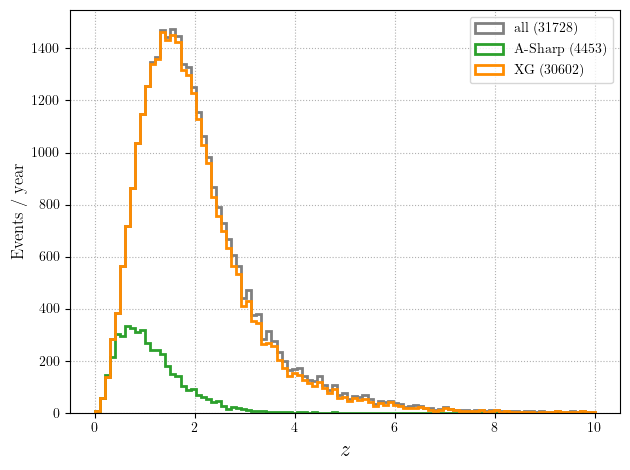

In [19]:
bins = np.linspace(0,10,100)
plt.hist(input_pop_snrs['XG']['total']['redshift'], histtype=u'step', label=f"all ({len(input_pop_snrs['XG']['total']['redshift'])})", 
         bins=bins, linewidth=2, color='grey')
plt.hist(input_pop_snrs['A-Sharp']['detected']['redshift'], histtype=u'step', color='tab:green', 
         label=f"A-Sharp ({len(input_pop_snrs['A-Sharp']['detected']['redshift'])})", bins=bins, linewidth=2)
plt.hist(input_pop_snrs['XG']['detected']['redshift'], histtype=u'step', color='darkorange',
         label=f"XG ({len(input_pop_snrs['XG']['detected']['redshift'])})", bins=bins, linewidth=2)
plt.legend()
plt.grid(ls=':')
plt.xlabel('$z$', fontsize=16)
plt.ylabel('Events / year', fontsize=12)
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, 'hist_z_events_detected_Asharp_XG_all.png'), dpi=300)

/tmp/ipykernel_8022/1059002197.py:6: RuntimeWarning: invalid value encountered in divide
  eff_samples = ns_sel/ns_tot


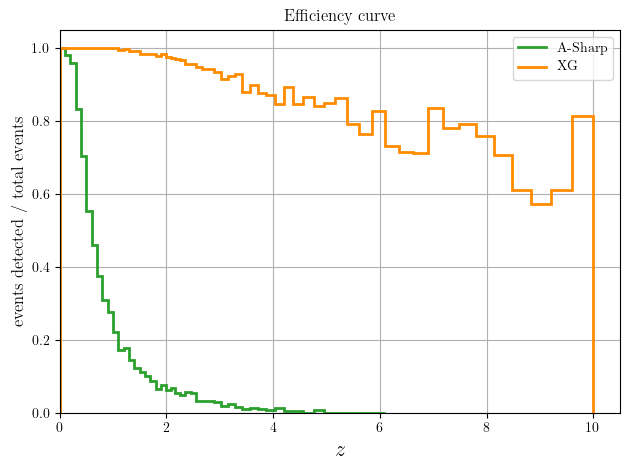

In [20]:
bins = np.concatenate([np.arange(0,2,0.1), np.logspace(np.log10(2),1,40)])
for netw, colr in zip(netws, ['tab:green', 'darkorange']):
    plot_efficiency_curve(input_pop_snrs[netw]['detected']['redshift'], input_pop_snrs[netw]['total']['redshift'], 
                          bins=bins, zorder=2, linewidth=2, label=netw, color=colr)
#plt.legend()
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$z$', fontsize=16)
plt.ylabel('events detected / total events', fontsize=12)
plt.grid()
plt.title('Efficiency curve')
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, 'efficiency_curve_Asharp_XG.png'), dpi=300)

### Plot mass bands

In [21]:
mass_ranges = ['<40', '40-80', '>80']
for netw in netws:
    input_pop_snrs[netw]['detected_mass_bands'] = {}
    for m_range in mass_ranges:
        m_bool_slice = slice_mtotal_pop(input_pop_snrs[netw]['detected']['mtotal'], m_range)
        input_pop_snrs[netw]['detected_mass_bands'][m_range] = input_pop_snrs[netw]['detected'][m_bool_slice]

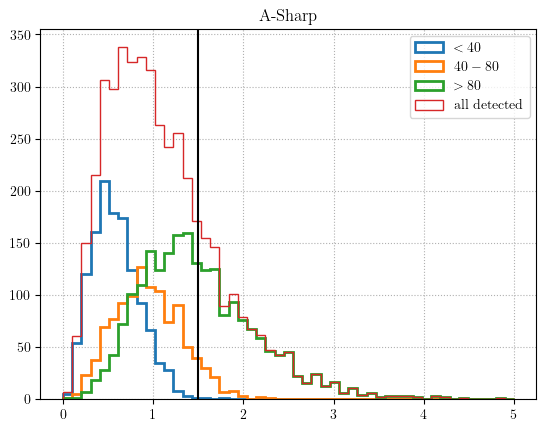

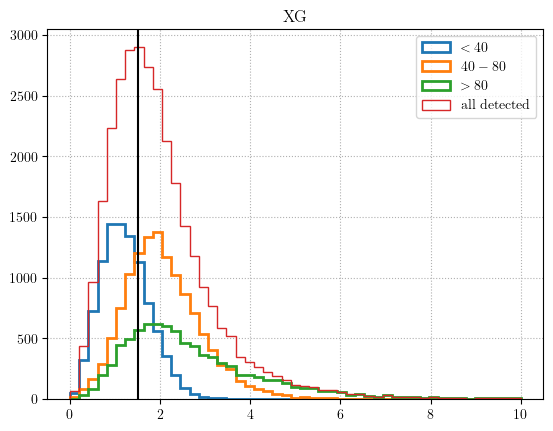

In [22]:
for netw, z_max in zip(netws, [5, 10]):
    bins = np.linspace(0, z_max, 50)
    plt.figure()
    for m_range in mass_ranges:
        plt.hist(input_pop_snrs[netw]['detected_mass_bands'][m_range]['redshift'], label=rf'${m_range}$', histtype=u'step', bins=bins, lw=2)
    plt.hist(input_pop_snrs[netw]['detected']['redshift'], label='all detected', bins=bins, histtype=u'step')
    plt.legend()
    plt.grid(ls=':')
    plt.title(netw)
    plt.axvline(1.5, c='k')

In [23]:
input_pop_snrs['A-Sharp']['detected_mass_bands']['<40'][input_pop_snrs['A-Sharp']['detected_mass_bands']['<40']['redshift'] > 1.5]

,SNR_H1,SNR_I1,SNR_L1,SNR_mf_H1,SNR_mf_I1,SNR_mf_L1,SNR_mf_from_opt_H1,SNR_mf_from_opt_I1,SNR_mf_from_opt_L1,SNR_mf_from_opt_network,SNR_mf_network,SNR_network,mtotal,redshift
5286,5.822008,6.476510,7.361303,6.206060,6.238526,6.624662,5.449193,6.614463,8.922154,12.371324,11.014559,11.403058,37.380890,1.514921
20261,6.058621,5.700144,7.165186,6.535132,4.935298,6.929657,9.077006,5.107229,6.517842,12.286501,10.727781,10.979000,39.811324,1.569824
22984,2.947685,6.294068,3.729957,5.039859,6.278103,5.255947,5.540528,9.920445,5.898686,12.802623,9.614559,7.887758,37.275931,1.817797


# SNR distribution

## Load FM errors

In [153]:
def load_results_from_h5(filename):
    results = {}

    with h5py.File(filename, 'r') as f:
        # Load original inj_params
        all_inj_params_original = []
        all_inj_original_group = f['all_inj_params_original']
        print('loading injection parameters')
        for i in tqdm(sorted(all_inj_original_group.keys(), key=lambda x: int(x))):
            param_group = all_inj_original_group[i]
            param_dict = {key: param_group[key][()] for key in param_group.keys() if 'PSD' not in key}
            all_inj_params_original.append(param_dict)
        results['all_inj_params_original'] = pd.DataFrame(all_inj_params_original)

        # Load errs
        errs = []
        errs_group = f['errs']
        print('loading errors')
        for i in tqdm(sorted(errs_group.keys(), key=lambda x: int(x))):
            err_group = errs_group[i]
            err_dict = {key: err_group[key][()] for key in err_group.keys()}
            errs.append(err_dict)
        results['errs'] = pd.DataFrame(errs)

    return results

In [159]:
fm_results = {}
for unique_key, netw in zip(['365', 'set3'], netws):
    print(netw)
    file_name = glob(os.path.join(project_dir, 'GWBench_analysis', 'BBH', f'*{netws[netw]}*{unique_key}*XPHM.h5'))
    print(file_name)
    fm_results[netw] = load_results_from_h5(file_name[0])

A-Sharp
['/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWBench_analysis/BBH/LHI_Asharp_1_PLP_z_MD_zmax_6_lmrd_22_no_spins_all_events_365_days_pop_from_XPHM.h5']
loading injection parameters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4340/4340 [00:35<00:00, 123.69it/s]


loading errors


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4340/4340 [00:07<00:00, 547.70it/s]


XG
['/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWBench_analysis/BBH/CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_set3_4344_events_pop_from_XPHM.h5']
loading injection parameters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4344/4344 [00:39<00:00, 110.25it/s]


loading errors


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4344/4344 [00:07<00:00, 586.61it/s]


In [160]:
fm_results['XG']['all_inj_params_original']

,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,SNR_E3,SNR_mf_C1,SNR_mf_CE20,SNR_mf_E1,SNR_mf_E2,SNR_mf_E3,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,39.209865,19.789934,8.486997,6.391365,8.317780,37.080921,21.666446,8.320932,6.705426,8.722132,...,-0.818220,-0.369847,0.018410,8.434837,6.643637,6.507558,15.078474,2.536432,832.853594,1.913900e+09
1,148.296443,71.604658,10.198201,17.095951,27.279531,149.134312,70.898532,9.904513,17.819629,27.175048,...,-0.102859,0.403177,0.897805,41.475570,33.271511,32.299819,74.747082,0.803373,922.252802,1.918850e+09
2,27.282928,20.455259,5.419970,8.775561,6.705731,26.504755,20.263543,5.569473,10.020520,7.414315,...,0.088863,0.159860,0.004676,9.711165,5.700530,6.431938,15.411694,0.829752,379.070270,1.910825e+09
3,39.397517,6.577393,34.131512,35.411659,35.018103,39.379683,6.865312,33.109686,35.799907,35.798095,...,-0.124049,0.181660,-0.960529,8.301588,7.592030,6.909823,15.893618,2.423342,739.503005,1.920672e+09
4,97.049780,62.222357,17.318850,17.568264,1.137546,95.520572,62.302818,16.129804,17.146903,4.920624,...,0.019233,0.006600,-0.081912,21.281204,20.646220,18.247460,41.927424,2.581289,1115.920637,1.919164e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,60.026765,51.060017,22.549182,26.937775,32.165631,59.478907,50.995234,22.547402,26.799947,32.401509,...,0.547381,-0.183427,0.773432,12.331898,8.680169,8.979272,21.012068,0.255374,38.414774,1.911239e+09
4340,17.997347,9.231844,10.691612,9.764433,10.944234,18.425295,10.943628,11.741826,9.754757,10.112946,...,0.005587,-0.005697,-0.007893,12.530316,4.441673,6.329343,16.971989,2.157180,151.002957,1.904868e+09
4341,8.346995,6.347255,9.273149,9.181634,9.192626,8.239583,7.202489,7.011328,9.628240,8.773080,...,-0.005118,0.023270,-0.688081,10.472780,4.727853,6.032027,15.200634,2.374309,511.569494,1.923025e+09
4342,79.840365,47.736003,37.966603,30.334920,34.998279,78.509875,47.371597,36.448179,30.937146,36.316600,...,-0.009329,0.113856,-0.006515,9.580518,8.644057,7.920133,18.224575,2.038948,451.417580,1.909231e+09


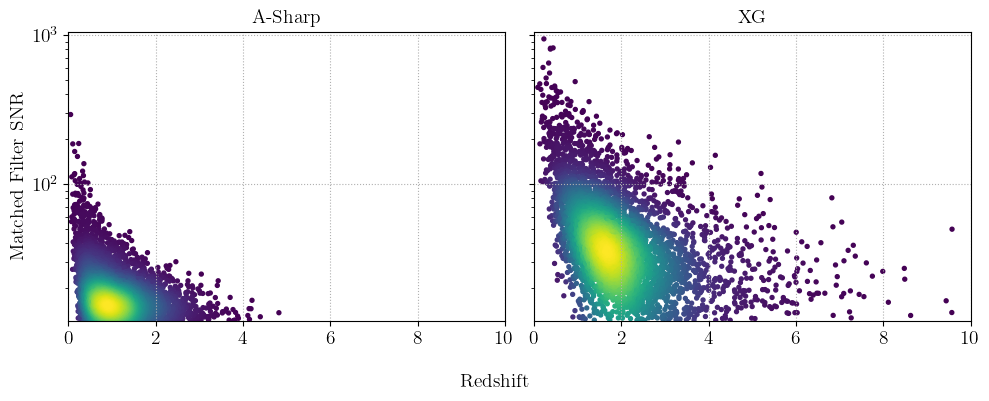

In [185]:
from scipy.stats import gaussian_kde

fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
for i, netw in enumerate(netws):
    df = fm_results[netw]['all_inj_params_original']
    x = df['redshift'].values
    y = df['SNR_mf_from_opt_network'].values

    # Stack and compute 2D point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort to plot densest points on top
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Scatter with density as color
    sc = axs[i].scatter(x, y, c=z, s=8, cmap='viridis')
    axs[i].set_yscale('log')
    axs[i].set_title(netw, fontsize=14)
    axs[i].grid(ls=':')
    axs[i].set_ylim(12,1050)
    axs[i].set_xlim(0,10)
    axs[i].tick_params(labelsize=14)
fig.supxlabel('Redshift', fontsize=14)
axs[0].set_ylabel('Matched Filter SNR', fontsize=14)
#axs[1].tick_params(labelleft=True)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'scatter_snr_vs_z_asharp_xg.png'), dpi=300)

# $\Delta z$ as a function of $z$

In [186]:
z_posterior_files = {'A-Sharp': os.path.join(project_dir, 'gwpopulation', 'BBH', 'LHI_Asharp_1_PLP_z_MD_zmax_6_lmrd_22_no_spins_all_events_365_days_z_posteriors_original_cov_4339_events_pop_from_XPHM.pkl'), 
                     'XG': os.path.join(project_dir, 'gwpopulation', 'BBH', 'CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_set3_z_posteriors_original_cov_4344_events_pop_from_XPHM.pkl')}

In [187]:
z_pos_all_events = {}
for netw in z_posterior_files.keys():
    z_pos_all_events[netw] = {'posteriors': pd.read_pickle(z_posterior_files[netw])}

In [188]:
def calc_5th_perc(arr):
    return(np.quantile(arr, 0.05))
def calc_95th_perc(arr):
    return(np.quantile(arr, 0.95))

In [189]:
for netw in netws:
    num_events = len(z_pos_all_events[netw]['posteriors'])
    z_pos_all_events[netw]['medians'] = np.array([np.median(z_pos_all_events[netw]['posteriors'][event]['redshift']) for event in range(num_events)])
    z_pos_all_events[netw]['5th_perc'] = np.array([np.quantile(z_pos_all_events[netw]['posteriors'][event]['redshift'], 0.05) for event in range(num_events)])
    z_pos_all_events[netw]['95th_perc'] = np.array([np.quantile(z_pos_all_events[netw]['posteriors'][event]['redshift'], 0.95) for event in range(num_events)])
    z_pos_all_events[netw]['error_intervals'] = z_pos_all_events[netw]['95th_perc'] - z_pos_all_events[netw]['5th_perc']

In [190]:
z_pos_all_events_df = {}
for netw in netws:
    z_pos_all_events_df[netw] = pd.DataFrame(z_pos_all_events[netw])
    z_pos_all_events_df[netw].sort_values('medians', ignore_index=True, inplace=True)
z_pos_all_events_df['A-Sharp']

,posteriors,medians,5th_perc,95th_perc,error_intervals
0,redshift prior 0 0.050205 0.0002 ...,0.049814,0.049407,0.050214,0.000806
1,redshift prior 0 0.075221 0.000...,0.069014,0.057879,0.080874,0.022995
2,redshift prior 0 0.069570 0.000...,0.069191,0.062993,0.075888,0.012894
3,redshift prior 0 0.065882 0.000...,0.075368,0.056611,0.098632,0.042021
4,redshift prior 0 0.079890 0.000...,0.086489,0.054963,0.178900,0.123937
...,...,...,...,...,...
4334,redshift prior 0 4.691420 0.000...,4.393853,2.992471,5.622842,2.630371
4335,redshift prior 0 4.648289 0.000...,4.396853,3.182156,5.722724,2.540568
4336,redshift prior 0 10.338102 0.0...,4.734765,1.780438,10.191009,8.410571
4337,redshift prior 0 4.392387 0.000...,5.625181,3.537529,7.879156,4.341627


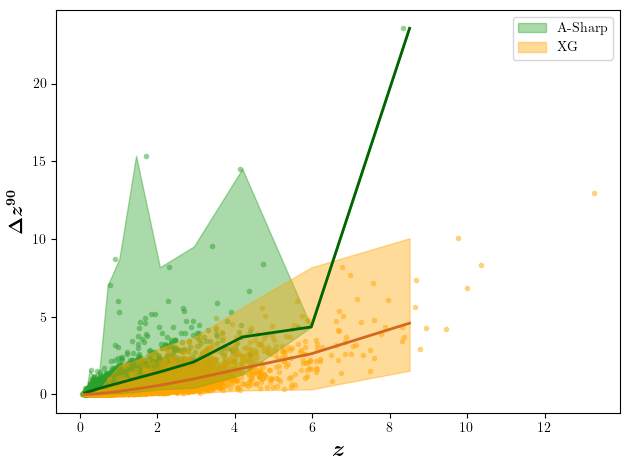

In [196]:
#bins = np.arange(0,10,0.9)
bins = np.logspace(-1, 1, 14)
for netw, colr, lc in zip(netws, ['tab:green', 'orange'], ['darkgreen', 'chocolate']):
    means, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals'], bins=bins)
    maxs, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals'], bins=bins, statistic='max')
    mins, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals'], bins=bins, statistic='min')
    
    #mins = [0] + list(mins)
    #maxs = [0] + list(maxs)
    #means = [0] + list(means)
    #edges_midpts = [0] + list((edges[:-1] + edges[1:])/2)
    edges_midpts = list((edges[:-1] + edges[1:])/2)
    
    plt.plot(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals'], '.', c=colr, alpha=0.5, zorder=0, mew=0, ms=8)
    plt.plot(edges_midpts, means, c=lc, lw=2)
    plt.fill_between(edges_midpts, mins, maxs, alpha=0.4, color=colr, label=netw)
plt.legend()
plt.xlabel(r'$\boldsymbol{z}$', fontsize=16, fontweight='bold')
plt.ylabel(r'$\boldsymbol{\Delta z^{90}}$', fontsize=14, fontweight='bold')
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, 'deltaz90_from_posteriors_vs_z_median_asharp_xg_max_min_mean_bands.png'), dpi=300)

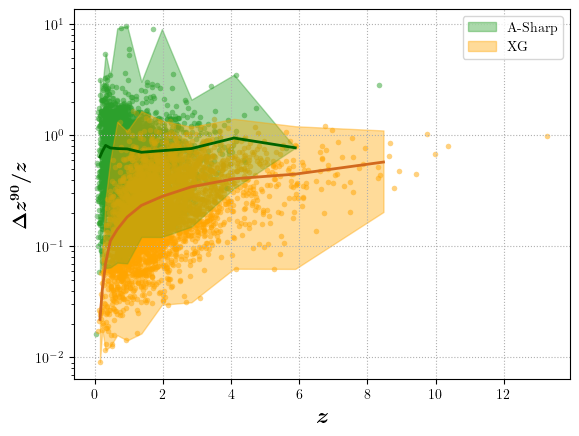

In [210]:
#bins = np.array([0, 0.1] + list(np.arange(0.2,10,0.9)))
bins = np.logspace(-0.9, 1, 13)
for netw, colr, lc in zip(netws, ['tab:green', 'orange'], ['darkgreen', 'chocolate']):
    means, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals']/z_pos_all_events_df[netw]['medians'], bins=bins)
    maxs, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals']/z_pos_all_events_df[netw]['medians'], bins=bins, statistic='max')
    mins, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals']/z_pos_all_events_df[netw]['medians'], bins=bins, statistic='min')
    
    edges_midpts = list((edges[:-1] + edges[1:])/2)
    
    plt.plot(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals']/z_pos_all_events_df[netw]['medians'], '.', c=colr, alpha=0.5, zorder=0, mew=0, ms=8)
    if netw == 'A-Sharp':
        plt.plot(edges_midpts[:-1], means[:-1], c=lc, lw=2)
        plt.fill_between(edges_midpts[:-1], mins[:-1], maxs[:-1], alpha=0.4, color=colr, label=netw)
    else:
        plt.plot(edges_midpts, means, c=lc, lw=2)
        plt.fill_between(edges_midpts, mins, maxs, alpha=0.4, color=colr, label=netw)
plt.legend()
plt.xlabel(r'$\boldsymbol{z}$', fontsize=16, fontweight='bold')
plt.ylabel(r'$\boldsymbol{\Delta z^{90}/z}$', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(ls=':')
plt.savefig(os.path.join(plot_dir, 'deltaz90_by_z_from_posteriors_vs_z_median_asharp_xg_max_min_mean_bands.png'), dpi=300)

# Posteriors for hyperparameters - complete populations

## Load result files

In [215]:
import bilby

In [216]:
pop_res_files = {'A-Sharp': glob(os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 'Asharp', 
                                              'run03_original_cov_mf_from_opt_SNR_injections_XPHM', '*.hdf5'))[0], 
                 'CE4020ET123': glob(os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 'CE4020ET123', 
                                                  'run07_original_cov_mf_from_opt_SNR_injections_XPHM', '*.hdf5'))[0]}

In [217]:
pop_results = {}
for netw, key in zip(netws, pop_res_files.keys()):
    pop_results[netw] = bilby.result.read_in_result(filename=pop_res_files[key])

In [218]:
pop_results['A-Sharp'].posterior

,gamma,kappa,log_likelihood,log_prior,z_peak
0,1.416143,6.094937,39220.827130,-5.857933,2.102359
1,0.504553,5.533439,39222.273224,-5.857933,3.017447
2,0.852548,3.521044,39222.422684,-5.857933,2.273222
3,0.920619,3.548200,39223.660689,-5.857933,2.198099
4,0.706292,12.355226,39223.716489,-5.857933,2.607365
...,...,...,...,...,...
3194,0.959445,5.967045,39233.192297,-5.857933,2.302998
3195,0.950525,5.872821,39233.196370,-5.857933,2.298320
3196,0.955839,5.950104,39233.198212,-5.857933,2.300599
3197,0.924685,5.923415,39233.198880,-5.857933,2.333760


## Add the new parameter which is peak of the curve

In [219]:
def z_peak_new(gamma, kappa, z_peak):
    new_peak = (gamma/(kappa-gamma))**(1/kappa) * (1+z_peak) - 1
    return(new_peak)

In [220]:
true_params = {'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}
true_params['z_peak_new'] = z_peak_new(**true_params)

In [221]:
for netw in netws:
    pop_results[netw].posterior.loc[:, 'z_peak_new'] = z_peak_new(pop_results[netw].posterior['gamma'], 
                                                                  pop_results[netw].posterior['kappa'], 
                                                                  pop_results[netw].posterior['z_peak'])

In [222]:
pop_results['A-Sharp'].posterior

,gamma,kappa,log_likelihood,log_prior,z_peak,z_peak_new
0,1.416143,6.094937,39220.827130,-5.857933,2.102359,1.549969
1,0.504553,5.533439,39222.273224,-5.857933,3.017447,1.651491
2,0.852548,3.521044,39222.422684,-5.857933,2.273222,1.367209
3,0.920619,3.548200,39223.660689,-5.857933,2.198099,1.379708
4,0.706292,12.355226,39223.716489,-5.857933,2.607365,1.875179
...,...,...,...,...,...,...
3194,0.959445,5.967045,39233.192297,-5.857933,2.302998,1.504068
3195,0.950525,5.872821,39233.196370,-5.857933,2.298320,1.492763
3196,0.955839,5.950104,39233.198212,-5.857933,2.300599,1.499816
3197,0.924685,5.923415,39233.198880,-5.857933,2.333760,1.507326


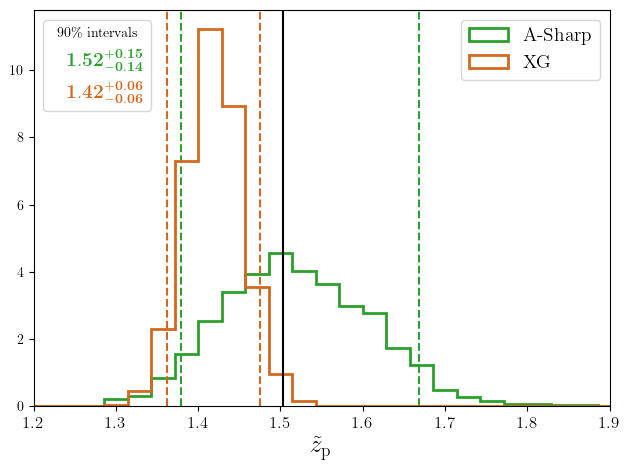

In [230]:
import matplotlib.lines as mlines

colors = ['tab:green', 'chocolate']
bins = np.linspace(1, 2.4, 50)
leg_text = []
for netw, colr in zip(netws, colors):
    histdata = pop_results[netw].posterior['z_peak_new']
    ci5 = np.quantile(histdata, 0.05)
    ci95 = np.quantile(histdata, 0.95)
    ci50 = np.median(histdata)
    
    plt.hist(histdata, label=netw, lw=2,
             density=True, histtype=u'step', bins=bins, color=colr)
    plt.axvline(ci5, c=colr, ls='--')
    plt.axvline(ci95, c=colr, ls='--')

    leg_text.append('$\mathbf{%s_{-%s}^{+%s}}$'%(round(ci50, 2), round(ci50-ci5, 2), round(ci95-ci50, 2)))

l1 = mlines.Line2D([], [], color=colors[0], label=leg_text[0])
l2 = mlines.Line2D([], [], color=colors[1], label=leg_text[1])

legend1 = plt.legend(handles=[l1,l2], handlelength=0, labelcolor='linecolor', 
                         title='90\% intervals', fontsize=14, loc=2)
plt.gca().add_artist(legend1)

plt.axvline(true_params['z_peak_new'], c='k')
plt.legend(fontsize=14)
plt.xlabel('$\\tilde{z}_{\mathrm{p}}$', fontsize=18)
plt.xlim(1.2, 1.9)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'posteriors_z_peak_new_Asharp_XG.png'), dpi=300)

# Posteriors for hyperparameters - mass bands

## Load result files

In [7]:
import bilby
import os

In [8]:
mass_bands = ['below_40', '40-80', 'above_80']
runs = {'Asharp': ['run01', 'run01', 'run03'], 
        'CE4020ET123': ['run01']*3}
netws = ['Asharp', 'CE4020ET123']
pop_res_files = {}
for netw in netws:
    pop_res_files[netw] = {}
    for m_range, run in zip(mass_bands, runs[netw]):
        pop_res_files[netw][m_range] = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                                                    netw, 'mass_bands', m_range, 
                                                    f'{run}_original_cov_mf_from_opt_SNR_injections_XPHM', f'{netw}_result.hdf5')

In [9]:
pop_results = {}
for netw in netws:
    pop_results[netw] = {}
    for m_range in mass_bands:
        pop_results[netw][m_range] = bilby.result.read_in_result(filename=pop_res_files[netw][m_range])

In [10]:
pop_results['Asharp']['40-80'].posterior

,gamma,kappa,log_likelihood,log_prior,z_peak
0,1.512586,8.538426,14743.219551,-5.857933,2.172296
1,0.831588,10.818228,14744.277032,-5.857933,2.341915
2,3.249223,4.870821,14746.287641,-5.857933,0.965935
3,0.591720,12.495350,14746.291404,-5.857933,2.595195
4,0.409561,9.286942,14746.306155,-5.857933,2.593889
...,...,...,...,...,...
3301,1.570589,5.261269,14754.288090,-5.857933,1.761093
3302,1.574374,5.211264,14754.291308,-5.857933,1.753738
3303,1.472699,5.383304,14754.293600,-5.857933,1.844827
3304,1.536516,5.223347,14754.296691,-5.857933,1.780758


## Add the new parameter which is peak of the curve

In [11]:
def z_peak_new(gamma, kappa, z_peak):
    new_peak = (gamma/(kappa-gamma))**(1/kappa) * (1+z_peak) - 1
    return(new_peak)

In [12]:
true_params = {'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}
true_params['z_peak_new'] = z_peak_new(**true_params)

In [13]:
for netw in netws:
    for m_range in mass_bands:
        pop_results[netw][m_range].posterior.loc[:, 'z_peak_new'] = z_peak_new(pop_results[netw][m_range].posterior['gamma'], 
                                                                               pop_results[netw][m_range].posterior['kappa'], 
                                                                               pop_results[netw][m_range].posterior['z_peak'])
        #drop nan
        pop_results[netw][m_range].posterior.dropna(inplace=True)
        # remove points with z_peak_new above 99 percentile to avoid outliers
        points_c99 = (pop_results[netw][m_range].posterior['z_peak_new'] < np.quantile(pop_results[netw][m_range].posterior['z_peak_new'], 0.99))
        points_positive = (pop_results[netw][m_range].posterior['z_peak_new'] > 0)
        pop_results[netw][m_range].posterior = pop_results[netw][m_range].posterior[points_c99 & points_positive]

In [14]:
def m_range_labels(mass_range):
    if 'below' in mass_range:
        return(mass_range.replace('below_', ' $<$ '))
    elif 'above' in mass_range:
        return(mass_range.replace('above_', ' $>$ '))
    else:
        return(mass_range.replace('_', ' - '))

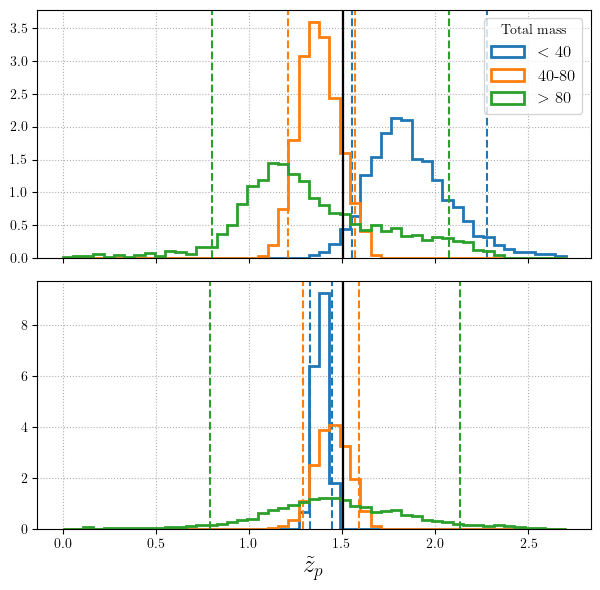

In [22]:
fig, axs = plt.subplots(2,1, figsize=(6,6), sharex=True)
bins = np.linspace(0, 2.7, 50)
for i, netw in enumerate(netws):
    for m_range in mass_bands:
        post_zp_new = pop_results[netw][m_range].posterior['z_peak_new']
        hist = axs[i].hist(post_zp_new, histtype=u'step', 
                           bins=bins, label=m_range_labels(m_range), density=True, lw=2)
        color = hist[2][0].get_edgecolor()
        ci5 = np.quantile(post_zp_new, 0.05)
        ci95 = np.quantile(post_zp_new, 0.95)
        axs[i].axvline(ci5, color=color, ls='--')
        axs[i].axvline(ci95, color=color, ls='--')
        
        axs[i].grid(ls=':')
        axs[i].axvline(true_params['z_peak_new'], c='k')
axs[0].legend(loc=1, title='Total mass', fontsize=12)
axs[1].set_xlabel('$\\tilde{z}_p$', fontsize=18)
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, 'hist_zp_new_mass_bands.png'), dpi=300)